In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pd.options.display.float_format = '{:.4f}'.format

def get_row(n_total, n_cols) :
    if n_total % n_cols == 0 :
        n_rows = n_total / n_cols
    else :
        n_rows = (n_total // n_cols) + 1
    return int(n_rows)

def visualize_articles(articles , article_list, n_total , n_cols , figsize=(25,10)) :
    n_rows = get_row(n_total , n_cols)
    f, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = ax.flatten()
    i = 0
    for article in article_list:
        visualize_article(axes , i , articles , article)
        i += 1
    else :
        plt.show()


def visualize_article(axes,i, articles , article) :
    desc = articles[articles['article_id'] == article]['detail_desc'].iloc[0]
    desc_list = desc.split(' ')
    for j, elem in enumerate(desc_list):
        if j > 0 and j % 5 == 0:
            desc_list[j] = desc_list[j] + '\n'
    desc = ' '.join(desc_list)
    try :
        img = mpimg.imread(f'../input/h-and-m-personalized-fashion-recommendations/images/0{str(article)[:2]}/0{int(article)}.jpg')
        axes[i].imshow(img)
    except :
        pass
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])
    axes[i].set_title(article)
    axes[i].grid(False)
    axes[i].set_xlabel(desc, fontsize=10)
    
    
    

def check_count(a,b,a_name="" , b_name="") :
    itersection_set = set(a) & set(b)
    a_uni_set = set(a).difference(set(b))
    b_uni_set = set(b).difference(set(a))
    print("="*20)
    print(a_name , len(a))
    print(b_name , len(b))
    print(a_name , "unique_set" , len(a_uni_set))
    print(b_name , "unique_set" , len(b_uni_set))
    print("intersection" , len(itersection_set))
    print("="*20)

In [3]:
data_submission_path = "/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv"
data_article_path = "/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv"
data_transaction_path = "/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv"
data_customer_path = "/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv"

check submission

* The transaction table does not contain all of the customer IDs in the submission table.

**In my opinion, a different approach is needed for customers who are not included.**

# Customer

In [4]:
customer = pd.read_csv(data_customer_path,usecols = ['customer_id'])
customer.nunique()

customer_id    1371980
dtype: int64

In [6]:
customer = pd.read_csv(data_customer_path,usecols = ['customer_id','age','club_member_status',"Active"])
pd.DataFrame(customer['age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
age,1356119.0000,36.3870,14.3136,16.0000,24.0000,32.0000,49.0000,99.0000


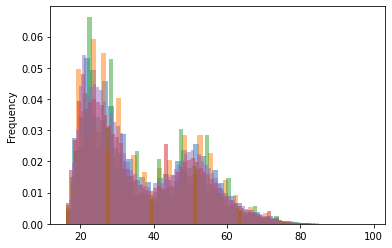

In [8]:
for bins in np.arange(50,100,10) :
    customer["age"].plot.hist(bins=bins,density =True,alpha=0.5)
plt.show()

## Age Binning

In [9]:
labels = ["10","20","30","40","50","60","70","80","90","100"]
labels_number = [int(label) for label in labels]
labels = [f"{label}'s" for label in labels]
d = pd.cut(customer["age"],labels_number,include_lowest=True, right=False, labels=labels[:-1])
customer["age_binned"] = pd.Categorical(d , categories=labels[:-1], ordered=True)

In [ ]:
customer["age_binned"].value_counts(sort=False)

In [ ]:
customer["age_binned"].value_counts(sort=False).plot.barh()

In [ ]:
customer.query("age != age").shape

In [12]:
customer_binned = customer

In [11]:
customer.columns

Index(['customer_id', 'Active', 'club_member_status', 'age', 'age_binned'], dtype='object')

In [13]:
customer['club_member_status'].unique()

array(['ACTIVE', nan, 'PRE-CREATE', 'LEFT CLUB'], dtype=object)

<AxesSubplot:xlabel='age_binned,club_member_status'>

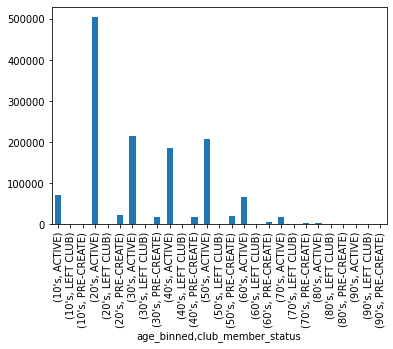

In [14]:
customer.groupby(["age_binned","club_member_status"]).size().plot(kind = "bar")

# Special Customer (no transactions)

* these customers does not have a transaction information.

**Let's analyze these customers!**

In [15]:
a = check_customer.groupby(["age_binned","Active"]).size().reset_index()
a = a[a[0] > 0]

NameError: name 'check_customer' is not defined

In [ ]:
total_n = len(list(a.age_binned.unique()))
n_cols = 4
n_rows = get_row(total_n , n_cols)
figsize = (15,6)
f, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
axes = ax.flatten()
i = 0
for age_binned in list(a.age_binned.unique()) :
    table = a[a.age_binned.str.contains(age_binned)].drop("age_binned",axis=1).set_index("Active")
    table = pd.Series(table.values.squeeze(),index= table.index)
    colors = sns.color_palette('Paired')
    axes[i].pie(table, 
           labels=[f"Active : {int(i)}" for i in table.index.tolist()],
           autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
    axes[i].axis('equal')
    axes[i].set_title(age_binned)
    i += 1
else :
    plt.show()



# We will see if there is any seasonality

In [16]:
article = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
transaction = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')

In [20]:
#We will join with article id
article_and_transaction =  pd.merge(article[['article_id','product_type_name']],transaction[['article_id','t_dat']],on='article_id')

In [21]:
article_and_transaction['year'] = pd.DatetimeIndex(article_and_transaction['t_dat']).year
article_and_transaction['month'] = pd.DatetimeIndex(article_and_transaction['t_dat']).month

In [22]:
article_and_transaction.head(4)

,article_id,product_type_name,t_dat,year,month
0,108775015,Vest top,2018-09-20,2018,9
1,108775015,Vest top,2018-09-20,2018,9
2,108775015,Vest top,2018-09-20,2018,9
3,108775015,Vest top,2018-09-20,2018,9


In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

In [27]:
article_and_transaction_by_yr =  article_and_transaction.groupby(['product_type_name', 'year']).size().reset_index(name ='Total Amount')
g = article_and_transaction_by_yr.groupby(["product_type_name"]).apply(lambda x: x.sort_values(["Total Amount"], ascending = False)).reset_index(drop=True)
g = g.groupby('year').head(20).reset_index(drop=True)
g = g.sort_values('year')


In [24]:
fig = px.treemap(g, path=['product_type_name', 'year'], values='Total Amount')
fig.show()

# Most of the times 2019 has been the most lucerative year when it comes to number of sales

# Baby Bib has increased sales in 2020 but we dont have lot of samples

# Bucket hat has also increased in sales



 

In [34]:
# We are only taking the top 10 per month
article_and_transaction_by_month =  article_and_transaction.groupby(['product_type_name', 'month']).size().reset_index(name ='Total Amount')
g = article_and_transaction_by_month.groupby(["product_type_name"]).apply(lambda x: x.sort_values(["Total Amount"], ascending = False)).reset_index(drop=True)
g = g.groupby('month').head(20).reset_index(drop=True)
g = g.sort_values('month')

In [35]:
fig = px.treemap(g, path=['product_type_name', 'month'], values='Total Amount')
fig.show()

# We dont see a lot of Blazers being bought on Winters

# We see which color is being most preferred and if it has any relation with season

In [36]:
#We will join with article id
article_and_transaction_color =  pd.merge(article[['article_id','colour_group_name']],transaction[['article_id','t_dat']],on='article_id')

<AxesSubplot:ylabel='colour_group_name'>

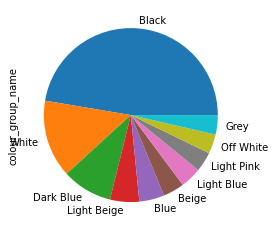

In [39]:
article_and_transaction_color['colour_group_name'].value_counts()[:10].plot(kind='pie')


# We will not see if we have relationship with month of the year and color people wear

In [40]:
article_and_transaction_color['year'] = pd.DatetimeIndex(article_and_transaction_color['t_dat']).year
article_and_transaction_color['month'] = pd.DatetimeIndex(article_and_transaction_color['t_dat']).month
# We are only taking the top 10 per month
article_and_transaction_color_by_month =  article_and_transaction_color.groupby(['colour_group_name', 'month']).size().reset_index(name ='Freq')
g = article_and_transaction_color_by_month.groupby(["colour_group_name"]).apply(lambda x: x.sort_values(["Freq"], ascending = False)).reset_index(drop=True)
g = g.groupby('month').head(15).reset_index(drop=True)
g = g.sort_values('month')

In [41]:
fig = px.treemap(g, path=['colour_group_name', 'Freq'], values='month')
fig.show()

# Most of the times the colors have usual pattern where End of the year there is increase which only tells that there is increase in sales and hence the increase in color freq

In [ ]:
article_and_transaction_color

In [ ]:
d = pd.read_csv(data_article_path,usecols=["product_type_name"])
table = pd.Categorical(d.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)
table.plot.bar(figsize=(21,4), rot=90)
plt.show()

In [ ]:
d = pd.read_csv(data_article_path,usecols=["graphical_appearance_name"])
table = pd.Categorical(d.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)
table.plot.bar(figsize=(16,4), rot=90)

In [ ]:
d = pd.read_csv(data_article_path,usecols=["colour_group_name"])
table = pd.Categorical(d.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)
table.plot.bar(figsize=(16,4), rot=90)

In [ ]:
d = pd.read_csv(data_article_path,usecols=["perceived_colour_value_name"])
table = pd.Categorical(d.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)
table.plot.bar(figsize=(16,4), rot=90)

In [ ]:
d = pd.read_csv(data_article_path,usecols=["index_name"])
table = pd.Categorical(d.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)
table.plot.bar(figsize=(7,3), rot=90)

In [ ]:
articles = pd.read_csv(data_article_path,usecols= ["article_id","section_name"])
articles.head()

In [ ]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def text_preprocessing(text):
    text = text.replace(" & ","&")
    text = text.replace(",","")
    text = text.lower()
    text = text.replace("womens","women")
    text = text.replace("mans","man")
    text = text.replace(" other 2","")
    text = text.strip()
    words = text.split(" ")
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in words]
    return lemm_text
articles['section_name_split']=articles['section_name'].apply(lambda x:text_preprocessing(x))

In [ ]:
articles['section_name_split'].head()

In [ ]:
dd = articles['section_name_split'].values.tolist()
unique_set = []
for d in dd :
    unique_set.extend(d)
else :
    keywords = list(np.unique(unique_set))
    print(len(keywords))
    print(keywords)

In [ ]:
def find_keywords(keyword , x) :
    return True if keyword in x else False
## women cloth

def get_keyword_count(articles, keyword) :
    sum_of_keyword = articles['section_name_split'].apply(lambda x : find_keywords(keyword, x)).sum()
    return sum_of_keyword

In [ ]:
keyword_count_table= {}
for keyword in keywords :
    keyword_count_table[keyword]= get_keyword_count(articles, keyword)

In [ ]:
keyword_count_table= pd.Series(keyword_count_table).sort_values(ascending=False)

In [ ]:
keyword_count_table.plot.bar(figsize=(17,5))
plt.show()

# Transaction

In [ ]:
data = pd.read_csv(data_transaction_path)

## Channels

In [ ]:
data['sales_channel_id'].value_counts()

In [ ]:
plt.hist(np.log(data.query("sales_channel_id==1")["price"]),bins=60,color="b",label="channel_id == 1",alpha=0.3,density=True)
plt.hist(np.log(data.query("sales_channel_id==2")["price"]),bins=60,color="r",label="channel_id == 2",alpha=0.3,density=True)
plt.legend()
plt.show()

## Count Table Based on the Date(t_dat)

In [ ]:
transaction_time = pd.to_datetime(data["t_dat"])

In [ ]:
table = pd.Categorical(transaction_time.dt.year.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)
table.plot.bar(figsize=(16,4), rot=90)

In [ ]:
table = pd.Categorical(transaction_time.dt.month.values.squeeze(),ordered=True).value_counts()
print(pd.DataFrame(table).T)
table.plot.bar(figsize=(16,4), rot=90)

In [ ]:
data["t_dat"] = transaction_time

In [ ]:
data.groupby(by=[data.t_dat.dt.month]).agg({"price" : ["min","max","mean","std"]})

In [ ]:
data.groupby(by=[data.t_dat.dt.year , data.t_dat.dt.month]).agg({"price" : ["min","max","mean","std"]})

In [ ]:
table = data.groupby(by=[data.t_dat.dt.year , data.t_dat.dt.month]).size()
table.index.names = ["year", "month"]

In [ ]:
table = table.reset_index(drop=False).rename(columns={0:"count"})
table = table.sort_values(by=["year","month"])
table["year/month"] = table.apply(lambda x : f'{x["year"]:04d}/{x["month"]:02d}',axis=1)

In [ ]:
table.plot(x = "year/month",y="count")

In [ ]:
fig = px.treemap(table, path=['year', 'month'], values='count')
fig.show()

In [ ]:
table = data.groupby(by=[data.t_dat.dt.dayofweek]).size()
table.index.names = ["dayofweek"]
table

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
colors = sns.color_palette('Paired')
ax.pie(table, 
       labels=['Mon','Tue',"Wed","Thr","Fri","Sat","Sun"],
       autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
ax.axis('equal')
plt.show()

In [ ]:
table = table.reset_index(drop=False)
table["isholiday"] = ['Weekdays','Weekdays','Weekdays','Weekdays','Weekdays','Holidays','Holidays']
table = table.groupby('isholiday').agg({0:"sum"})
table

In [ ]:
table = pd.Series(table.values.squeeze(),index = table.index.values)

In [ ]:
table

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
colors = sns.color_palette('Paired')
ax.pie(table, 
       labels=['Holidays',"Weekdays"],
       autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
ax.axis('equal')
plt.show()

In [ ]:
articles = pd.read_csv(data_article_path)

In [ ]:
top3_year_article_table = data.groupby([data.t_dat.dt.year]).apply(lambda x : x['article_id'].value_counts().head(3))
top3_year_article_table

In [ ]:
article_list = list(top3_year_article_table.reset_index()['level_1'].unique())
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 5 , figsize=(25,14))

In [ ]:
top3_month_article_table =  data.groupby([data.t_dat.dt.month]).apply(lambda x : x['article_id'].value_counts().head(3))
top3_month_article_table

In [ ]:
article_list = list(top3_month_article_table.reset_index()['level_1'].unique())
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 7 , figsize=(25,14))

In [ ]:
top3_dayofweek_article_table= data.groupby([data.t_dat.dt.dayofweek]).apply(lambda x : x['article_id'].value_counts().head(3))
top3_dayofweek_article_table

In [ ]:
article_list = list(top3_dayofweek_article_table.reset_index()['level_1'].unique())
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 3 , figsize=(25,14))

In [ ]:
article_count_table= data.article_id.value_counts()
top10 = article_count_table.head(10)
top10_articles = top10.index.values.tolist()


In [ ]:
visualize_articles(articles,top10_articles , n_total = len(top10_articles) , n_cols = 5 , figsize=(25,14))

In [ ]:
table = data.groupby(by=[data.t_dat.dt.year , data.t_dat.dt.dayofweek]).agg({"price" : ["mean"]})
table.index.names = ["year","dayofweek"]

In [ ]:
table = table.reset_index().droplevel(1,axis=1)
fig = px.treemap(table, path=['year', 'dayofweek'], values='price')
fig.show()

In [ ]:
customer_purchage_freq = data.groupby([data.customer_id]).size()

In [ ]:
customer_purchage_freq_greather_than_1000 = customer_purchage_freq[customer_purchage_freq > 1000]

In [ ]:
customer_purchage_freq_greather_than_1000

In [ ]:
n_of_customer = data.customer_id.nunique()

In [ ]:
f"{len(customer_purchage_freq_greather_than_1000)}/{n_of_customer}"

In [ ]:
customer_list =customer_purchage_freq_greather_than_1000.index.tolist()
sub_data = data.query("customer_id in @customer_list")

In [ ]:
sub_data.groupby("customer_id")["price"].describe()

In [ ]:
article_list = sub_data['article_id'].value_counts()
pd.DataFrame(article_list[article_list > 7]).T

In [ ]:
sub_data.groupby(["article_id","customer_id"]).size()

In [ ]:
regular_customer_articles_10 = sub_data.groupby(["article_id"]).agg({"customer_id" : ["count"]}).reset_index(drop=False).droplevel(1 ,axis=1).query("customer_id > 10")

In [ ]:
article_list = regular_customer_articles_10.article_id.values.tolist()

In [ ]:
article_list

In [ ]:
sub_data.query("article_id in @article_list").groupby(["article_id","customer_id"]).size()

In [ ]:
articles = pd.read_csv(data_article_path)

In [ ]:

## reference : https://www.kaggle.com/vanguarde/h-m-eda-first-look 
f, ax = plt.subplots(1, 6, figsize=(25,10))
axes = ax.flatten()
i = 0
for article in article_list:
    desc = articles[articles['article_id'] == article]['detail_desc'].iloc[0]
    desc_list = desc.split(' ')
    for j, elem in enumerate(desc_list):
        if j > 0 and j % 5 == 0:
            desc_list[j] = desc_list[j] + '\n'
    desc = ' '.join(desc_list)
    img = mpimg.imread(f'../input/h-and-m-personalized-fashion-recommendations/images/0{str(article)[:2]}/0{int(article)}.jpg')
    axes[i].imshow(img)
    axes[i].set_xticks([], [])
    axes[i].set_yticks([], [])
    axes[i].set_title(article)
    axes[i].grid(False)
    axes[i].set_xlabel(desc, fontsize=10)
    i += 1
plt.show()

# Special Customer (old age)


According to the customer age information, it can be confirmed that older people also make purchases.

* H&M targets woman in the lower middle class and working class, The target market for H&M is for younger people.

[reference](https://ukdiss.com/examples/marketing-analysis-h-and-m.php)

Although the company is targeting younger people, it wanted to identify products that would attract older people to buy as well.

At first, I thought it was an error in the data, but after actually analyzing it, I found that I was buying products with an older age group.

**Let's analyze these customers!**


In [ ]:
specal_customer_transaction_data = data.query("customer_id in @special_customer_list")

In [ ]:
specal_customer_transaction_data = pd.merge(specal_customer_transaction_data , customer_binned , how="left",on="customer_id")

In [ ]:
specal_customer_transaction_data.shape

In [ ]:
specal_customer_transaction_data.head()

In [ ]:
articles = pd.read_csv(data_article_path)
specal_customer_transaction_data = pd.merge(specal_customer_transaction_data , articles , how="left",on="article_id")

In [ ]:
specal_customer_transaction_data['garment_group_name'].value_counts()

In [ ]:
specal_customer_transaction_data['section_name'].value_counts()

In [ ]:
specal_customer_transaction_data['sales_channel_id'].value_counts()

In [ ]:
specal_customer_transaction_data['club_member_status'].value_counts()

In [ ]:
specal_customer_transaction_data['index_group_name'].value_counts()

In [ ]:
## reference : https://www.kaggle.com/junjitakeshima/h-m-easy-grouping-by-sex-attribute-age-en-jp
specal_customer_transaction_data_by_sex = specal_customer_transaction_data[["customer_id","index_group_name","article_id"]].groupby(["customer_id","index_group_name"]).count().unstack()
specal_customer_transaction_data_by_sex = specal_customer_transaction_data_by_sex.fillna(0)

In [ ]:
specal_customer_transaction_data_by_sex["attribute"] =specal_customer_transaction_data_by_sex.apply(lambda x : list(x[x == x.max()].index)[0][1], axis=1)

In [ ]:
specal_customer_transaction_data_by_sex_selected = specal_customer_transaction_data_by_sex.reset_index(drop=False)[["customer_id","attribute"]]

In [ ]:
specal_customer_transaction_data = pd.merge(specal_customer_transaction_data,specal_customer_transaction_data_by_sex_selected.droplevel(1,axis=1) , how="left",on="customer_id")

In [ ]:
specal_customer_transaction_data[["customer_id","article_id","attribute"]].head()

In [ ]:
specal_customer_transaction_data["attribute"].value_counts()

In [ ]:
article_list = specal_customer_transaction_data.query('attribute == "Menswear"').article_id.value_counts().head(6).index.tolist()
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 6 , figsize=(25,14))

In [ ]:
article_list = specal_customer_transaction_data.query('attribute == "Ladieswear"').article_id.value_counts().head(6).index.tolist()
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 6 , figsize=(25,14))

In [ ]:
article_list = specal_customer_transaction_data.query('attribute == "Divided"').article_id.value_counts().head(6).index.tolist()
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 6 , figsize=(25,14))

In [ ]:
article_list = specal_customer_transaction_data.query('attribute == "Sport"').article_id.value_counts().head(6).index.tolist()
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 6 , figsize=(25,14))

In [ ]:
acc_article_list = specal_customer_transaction_data[specal_customer_transaction_data['index_name'].str.contains("Accessories")].article_id.value_counts().head(6).index.tolist()
visualize_articles(articles,acc_article_list , n_total = len(acc_article_list) , n_cols = 6 , figsize=(25,14))

Some users probably bought clothes for their grandchildren.

In [ ]:
specal_customer_transaction_data_certain_garment = specal_customer_transaction_data.query('garment_group_name == "Woven/Jersey/Knitted mix Baby"')[["article_id","age_binned"]]
article_list = specal_customer_transaction_data_certain_garment['article_id'].unique().tolist()
visualize_articles(articles,article_list , n_total = len(article_list) , n_cols = 5 , figsize=(25,20))

In [ ]:
specal_customer_transaction_data_top_6 = specal_customer_transaction_data.groupby("age_binned").apply(lambda x : x['article_id'].value_counts().head(6))

In [ ]:
specal_customer_transaction_data_top_6 = specal_customer_transaction_data_top_6.reset_index(drop=False)
specal_customer_transaction_data_top_6

In [ ]:
f, ax = plt.subplots(2, 6, figsize=(25,15))
axes = ax.flatten()

i = 0
article_list = specal_customer_transaction_data_top_6.head(6)['level_1'].values.tolist()
for article in article_list:
    visualize_article(axes , i , articles , article)
    i += 1
article_list = specal_customer_transaction_data_top_6.tail(6)['level_1'].values.tolist()
for article in article_list:
    visualize_article(axes , i , articles , article)
    i += 1
plt.show()